In [2]:
from flatspin import SpinIce
import numpy as np
import matplotlib.pyplot as plt

class ShaktiLattice(SpinIce):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _init_geometry(self):
        nx = self.size[0]  # number of untc cells along x-axis
        ny = self.size[1]  # number of unit cells along y-axis

        nx_half = int(nx/2)
        ny_half = int(ny/2)
        base_count = 2 * ( nx * (ny + 1) + (nx + 1) * ny )

        if nx % 2 == 0: #even nx 
            if ny % 2 == 0: #even ny
                internal_count = 2 * (nx * ny) 
            else: #odd ny
                internal_count = 2 * (nx * (ny_half + 1) + nx * ny_half)
        else: #odd nx
            if ny % 2 == 0: #even ny
                internal_count = 2 * (nx_half * ny + (nx_half + 1) * ny)
            else: #odd ny
                internal_count = 2 * ( (nx_half + 1) * (ny_half + 1) + nx_half * ny_half + nx_half * (ny_half + 1) + (nx_half + 1) * ny_half)

        spin_count = base_count + internal_count

        pos = np.zeros((spin_count, 2), dtype=float)
        angle = np.zeros(spin_count, dtype=float)

        labels = []

        a = self.lattice_spacing
        y = 0
        i = 0
        flag=0

        for row in range(0, 4 * ny + 1):
            x = 0
            is_vert = row % 2  # 1 for vert, 0 for horz

            if is_vert == 1: # vertical row
                x=0
                ncols = nx + 1
                if flag==0 or flag==1: #on vert
                    if nx % 2 == 0: #even
                        ncols += nx_half 
                    else:
                        ncols += nx_half + 1
                elif flag==2 or flag==3: #alt vert
                    ncols += nx_half
            
            if is_vert == 0: # horizontal row
                if row % 4 == 0: #base horz
                    x = a/2
                    ncols = 2 * nx  
                elif (row - 6) % 8 == 0: #on horz
                    x = a/2
                    if nx % 2 == 0: #even
                        ncols = 2 * nx_half
                    else:
                        ncols = 2 * (nx_half +1)
                elif (row - 2) % 8 == 0: #alt horz
                    x = 5 * (a/2)
                    ncols = 2 * nx_half
            cflag=0
            for col in range(0, ncols):
                if is_vert==0:  #horizontal spins
                    angle[i] = 0
                    pos[i] = [x, y]
                    if row % 4 == 0:
                        x += a
                    elif ((row - 6) % 8 == 0) or ((row - 2) % 8 == 0):
                        if col % 2 ==0:
                            x += a
                        else:
                            x += 3 * a

                if is_vert==1:  #vertical spins
                    angle[i] = np.pi/2
                    pos[i] = [x, y]
                    if flag==0 or flag==1: #on 
                        if cflag==0 or cflag==1:
                            x += a
                            cflag+=1
                        elif cflag==2:
                            x += 2*a
                            cflag=0
                        
                    elif flag==2 or flag==3: #alt 
                        if cflag==0:
                            x += 2 * a
                            cflag+=1
                        elif cflag==1 or cflag == 2:
                            x += a
                            cflag+=1
                            if cflag==3:
                                cflag=0

                label = (row, col)
                labels.append(label)

                i += 1
            
            y += a / 2

            if is_vert == 1:
                if flag==0 or flag==1:
                    flag+=1
                elif flag==2 or flag==3:
                    flag+=1
                    if flag==4:
                        flag=0

        self.labels = np.array(labels)
        #print(pos)
        return pos, angle

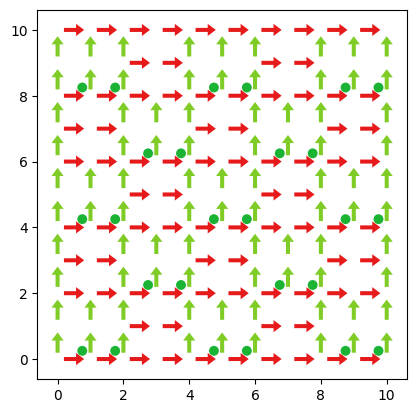

In [4]:
model = ShaktiLattice(size=(5,5), init='polarize', disorder=0.05)
model.plot()
#model.plot_vertex_mag();
model.plot_vertices()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


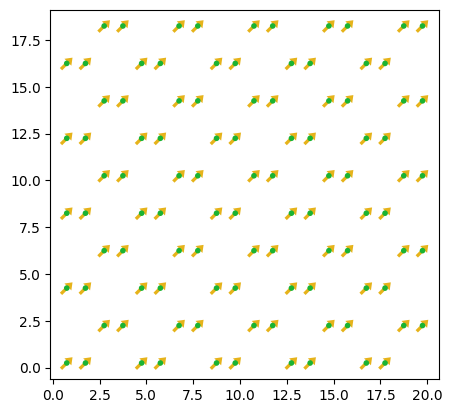

In [42]:
model.plot_vertex_mag();
model.plot_vertices()
vert = model.vertices()

typ = []
for v in vert:
    typ.append(model.vertex_type(v))
print(typ)

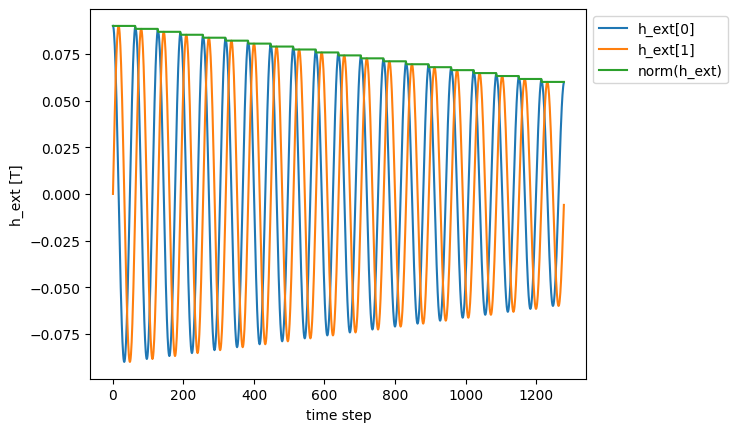

In [50]:
from flatspin.encoder import Rotate

timesteps = 64
enc_rotate = Rotate(H=0.09, H0=0.06, timesteps=timesteps)
input = np.linspace(1, 0, 20)

h_ext = enc_rotate(input)
H = np.linalg.norm(h_ext, axis=1)

plt.plot(h_ext[:,0], label="h_ext[0]")
plt.plot(h_ext[:,1], label="h_ext[1]")
plt.plot(np.linalg.norm(h_ext, axis=1), label="norm(h_ext)")
plt.xlabel("time step")
plt.ylabel("h_ext [T]")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

Completed 10764 steps


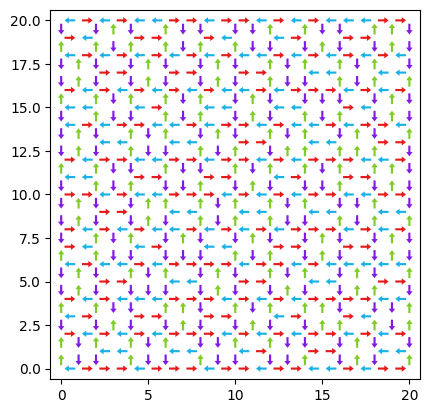

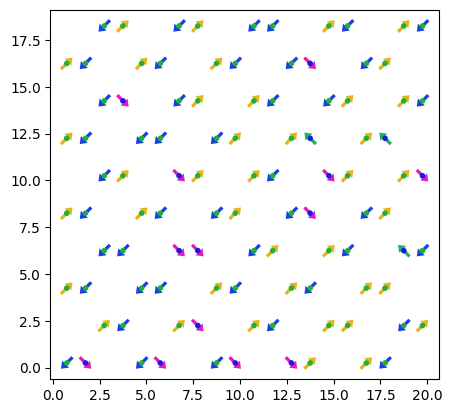

In [44]:
# Start in polarized state
model.polarize()

# Record spins, number of spin flips and dipolar energy over time
spins = []
flips = []
E_dip = []
for i, h in enumerate(h_ext):
    model.set_h_ext(h)
    s = model.relax()
    if (i+1) % timesteps == 0:
        # Record spin state at the end of each rotation
        spins.append(model.spin.copy())
    flips.append(s)
    E_dip.append(model.total_dipolar_energy())

model.plot()
plt.figure()
model.plot_vertex_mag()
model.plot_vertices()
print(f"Completed {sum(flips)} steps")

In [45]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, ax = plt.subplots()

def animate_spin(i):
    H = np.linalg.norm(h_ext[(i+1) * timesteps - 1])
    ax.set_title(f"H={H:.3f} [T]")
    model.set_spin(spins[i])
    model.plot_vertex_mag(ax=ax, replace=True)
        
anim = FuncAnimation(fig, animate_spin, frames=len(spins), interval=200, blit=False)
plt.close() # Only show the animation
HTML(anim.to_jshtml())


<Figure size 640x480 with 0 Axes>

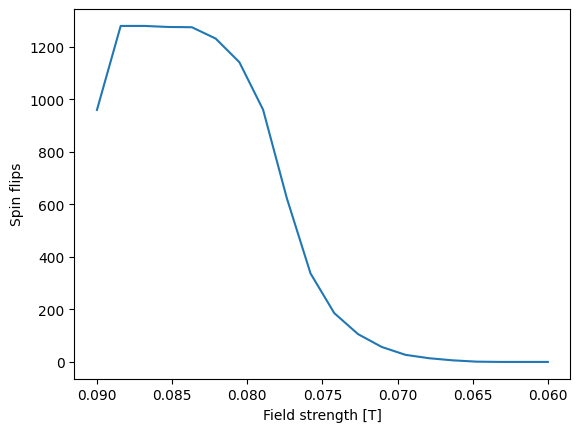

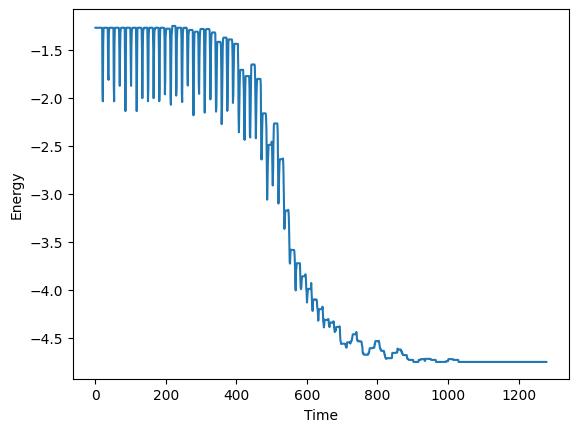

In [46]:
import pandas as pd
H = np.linalg.norm(h_ext, axis=-1).round(10)
df = pd.DataFrame({'H': H, 'flips': flips})
dd = df.groupby('H', sort=False).sum()

plt.figure()
dd.plot(legend=False)
plt.gca().invert_xaxis()
plt.ylabel("Spin flips")
plt.xlabel("Field strength [T]");
plt.figure()
plt.plot(E_dip)
plt.ylabel("Energy")
plt.xlabel("Time");